# Satellite Image Processing for Land Use and Land Cover Mask Generation

This notebook processes satellite images from CBERS 04A, which have dimensions of approximately 56074 x 57614 pixels. To facilitate manipulation, the images are cropped into smaller patches of 3840 x 3840 pixels.

Next, we utilize building polygon data from Open Buildings V3 Polygons to create binary masks that indicate the presence of constructions in the satellite images. Georeferencing ensures precise alignment between the images and the polygons.

This process generates a dataset prepared for land use analysis and segmentation model training.

## Creating Patches from the Original CBERS Images

The [CBERS 04A](http://www.cbers.inpe.br/lancamentos/cbers04a.php) satellite, part of the cooperation program between Brazil and China, was launched in 2019. Equipped with high-resolution cameras, it provides detailed images for environmental, agricultural, and urban monitoring. The images can be downloaded from the [website](http://queimadas.dgi.inpe.br/catalogo/explore) of the National Institute for Space Research (INPE).

The images are available with the RGB and PAN bands separated. After band composition to obtain a natural color image, a resolution of 8 meters per pixel is achieved. Then, pansharpening was performed to obtain a new image with a resolution of 2 meters per pixel. These processes were carried out using QGIS. The resulting images follow the example of Figure 1, with dimensions of approximately 56074 x 57614 pixels and a resolution of 2m/pixel.

Figure 1. Satellite image from the CBERS 04A sensor with natural colors.

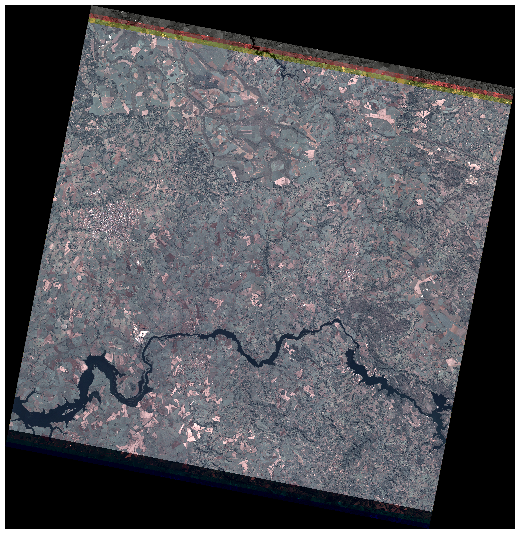

<span1 style="padding-right: 150px;"></span1>Source: Own elaboration.

Therefore, the first step in processing will be the creation of patches from the images, considering that these are very large images, and their processing and storage can present high computational costs.


In [ ]:
import os
import numpy as np
from PIL import Image
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine

In [ ]:
# Function to check if the patch contains black borders
def contains_black_borders(patch, threshold=10):
    gray_patch = patch.convert('L')
    np_patch = np.array(gray_patch)
    return np.any(np_patch[:threshold, :] == 0) or np.any(np_patch[-threshold:, :] == 0) or \
           np.any(np_patch[:, :threshold] == 0) or np.any(np_patch[:, -threshold:] == 0)

# Function to crop a patch while maintaining georeferencing
def recortar_patch(src, output_path, x_off, y_off, width, height):
    try:
        # Define the reading window
        window = Window(x_off, y_off, width, height)
        
        # Read the data from the specified window
        patch_data = src.read(window=window)
        
        # Update the affine transform for the cropped patch
        transform = src.window_transform(window)
        
        # Metadata for the output file
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": height,
            "width": width,
            "transform": transform,
            "compress": "lzw"  # Optional: compression to reduce file size
        })
        
        # Check if the patch contains black borders
        patch_image = Image.fromarray(patch_data.transpose(1, 2, 0))  # Convert to PIL image
        if not contains_black_borders(patch_image):
            # Write the output image
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(patch_data)
                
    except rasterio.errors.RasterioIOError as e:
        print(f"Error writing the patch to file {output_path}: {e}")
    except Exception as e:
        print(f"Unexpected error processing the patch in file {output_path}: {e}")

# Function to process all images in a directory
def process_images(input_directory, output_directory, patch_size):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for file_name in os.listdir(input_directory):
        if file_name.endswith('.tif'):
            input_path = os.path.join(input_directory, file_name)
            with rasterio.open(input_path) as src:
                width = src.width
                height = src.height
                
                patch_count = 0
                for i in range(0, width, patch_size):
                    for j in range(0, height, patch_size):
                        output_path = os.path.join(output_directory, f'{os.path.splitext(file_name)[0]}_patch_{patch_count}.tif')
                        recortar_patch(src, output_path, i, j, patch_size, patch_size)
                        patch_count += 1


In [ ]:
# Input and output directories
input_directory = '/home/luisa/Documentos/CBERS/images/composicao'
output_directory = '/home/luisa/Documentos/CBERS/images/IMAGES'
patch_size = 3840 # chosen size for the patches

# Process all images in the input directory
process_images(input_directory, output_directory, patch_size)

print(f'Patches saved in directory {output_directory}')

# Scan Open Buildings V3 Polygons File and Create Binary Masks for CBERS Images

The [Open Buildings V3 Polygons](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_Research_open-buildings_v3_polygons) is a geospatial dataset created by Google that provides detailed building polygons worldwide. Using advanced machine learning techniques, it accurately maps built-up areas, facilitating urban analysis, land planning, and large-scale land use studies.

To generate binary masks for CBERS images, it is necessary to match the images with the polygon data. A common approach is to use supervised classification techniques, such as machine learning (ML) with training data that contains built-up areas. Below, in Figure 2, we can see an example of a satellite image and its corresponding mask;

<span1 style="padding-right: 350px;"></span1>Figure 2. Satellite image and corresponding mask.

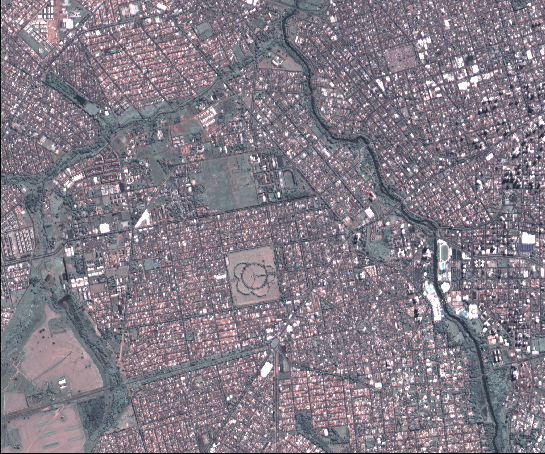  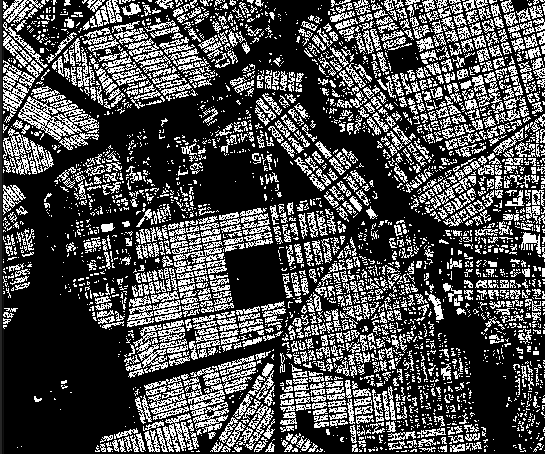

<span1 style="padding-right: 220px;"></span1>RGB Image<span2 style="padding-right: 450px;"> </span2>Binary Mask

The alignment between satellite images and polygon data is ensured through georeferencing, allowing precise matching between image coordinates and polygon coordinates. The following script performs the alignment and generates the masks.


In [ ]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import box
from rasterio.features import rasterize
import glob
import shutil

In [ ]:
cont = 0 # Modify cont after changing the CSV file for the Open Buildings tile

# Path to the CSV file
csv_file = '/home/luisa/Documentos/CBERS/masks_opb/935_buildings.csv'
input_folder = '/home/luisa/Documentos/CBERS/images/IMAGES/'
output_folder = '/home/luisa/Documentos/CBERS/masks/'
move_folder = '/home/luisa/Documentos/CBERS/images/processed/'

# Read the CSV
df = pd.read_csv(csv_file)

# Convert the WKT geometry column to shapely geometry, if needed
if df['geometry'].dtype == 'object':
    df['geometry'] = df['geometry'].apply(shapely.wkt.loads)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Set the CRS (coordinate reference system), assuming WGS84 here
gdf.set_crs(epsg=4326, inplace=True)

# Function to create the raster mask
def create_mask(gdf, image_shape, image_transform):
    shapes = ((geom, 1) for geom in gdf.geometry if not geom.is_empty)
    mask = rasterize(
        shapes,
        out_shape=image_shape,
        transform=image_transform,
        fill=0,
        dtype=np.uint8
    )
    # Binarize the mask (values 0 or 1)
    mask = np.where(mask > 0, 1, 0).astype(np.uint8)
    return mask


In [ ]:
# Iterate over all TIFF files in the input folder
for input_tif in glob.glob(os.path.join(input_folder, '*.tif')):
    with rasterio.open(input_tif) as src:
        image_bounds = src.bounds
        image_transform = src.transform
        image_crs = src.crs
        image_shape = src.shape

        # Create a polygon from the image bounds
        image_polygon = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)

        # Convert the GeoDataFrame to the same CRS as the image
        gdf = gdf.to_crs(image_crs)

        # Filter the polygons that are within the bounds of the TIFF image
        gdf_filtered = gdf[gdf.intersects(image_polygon)]

        # Check if there are valid geometries after filtering
        if gdf_filtered.empty:
            print(f"No polygons found within the bounds of TIFF image {input_tif}.")
            continue

        # Create the raster mask
        mask = create_mask(gdf_filtered, image_shape, image_transform)
        # Convert the mask to a PIL image and apply 'L' (grayscale)
        mask_image = Image.fromarray(mask * 255).convert('L')
        # Convert the image back to a numpy array
        mask = np.array(mask_image)

        # Check if the mask contains non-null values
        if np.any(mask):
            # Output file name
            output_mask_tif = os.path.join(output_folder, os.path.basename(input_tif).replace('.tif', '_mask.tif'))

            # Define the raster profile for the mask
            profile = src.profile
            profile.update(
                dtype=rasterio.uint8,
                count=1,
                compress='lzw'
            )

            # Save the raster mask to a new TIFF file
            with rasterio.open(output_mask_tif, 'w', **profile) as dst:
                dst.write(mask, 1)
                cont = cont + 1

            print(f"Raster mask saved to {output_mask_tif}")

            # Move the original image to the processed images folder
            shutil.move(input_tif, os.path.join(move_folder, os.path.basename(input_tif)))
            print(f"Original image moved to {move_folder}")
        else:
            print(f"No non-null values in the mask for image {input_tif}.")


### Joining Two Tiles to Create a Mask

There are cases where a satellite image is present in more than one Open Buildings tile.

In [ ]:
import pandas as pd
import geopandas as gpd
import shapely.wkt
from shapely.geometry import box
import rasterio
from rasterio.features import rasterize
import numpy as np
from PIL import Image
import shutil
import os

# Path to the CSV files
csv_files = [
    '/home/luisa/Documentos/CBERS/masks_opb/00b_buildings2.csv',
    '/home/luisa/Documentos/CBERS/masks_opb/075_buildings.csv'  # Add the second CSV file here
]

input_tif = '/home/luisa/Documentos/INTEGRA_M4/IMAGE_TEST_M4/CBERS/CBERS_4A_WPM_20200622_198_140_L4_B0.tif'
output_mask_tif = '/home/luisa/Documentos/IMAGENS_MACRO_4/imagens de teste/CBERS/mask.tif'
move_folder = '/home/luisa/Documentos/IMAGENS_MACRO_4/imagens de teste/CBERS/'

# Function to read and convert CSV to GeoDataFrame
def read_and_convert_csv(csv_file):
    df = pd.read_csv(csv_file)
    if df['geometry'].dtype == 'object':
        df['geometry'] = df['geometry'].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

# Combine the data from the two CSV files into a single GeoDataFrame
gdf_list = [read_and_convert_csv(csv_file) for csv_file in csv_files]
combined_gdf = pd.concat(gdf_list, ignore_index=True)
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')

# Read the georeferenced TIFF image
with rasterio.open(input_tif) as src:
    image_bounds = src.bounds
    image_transform = src.transform
    image_crs = src.crs
    image_shape = src.shape

    # Create a polygon from the image bounds
    image_polygon = box(image_bounds.left, image_bounds.bottom, image_bounds.right, image_bounds.top)

    # Convert the combined GeoDataFrame to the same CRS as the image
    combined_gdf = combined_gdf.to_crs(image_crs)

